<a href="https://colab.research.google.com/github/Harshanand7/GNR_602/blob/main/GNR602_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
crawford_deepsat_sat4_path = kagglehub.dataset_download('crawford/deepsat-sat4')

print('Data source import complete.')


Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import StandardScaler
import cupy as cp
from cuml.svm import SVC, LinearSVC
from cuml.model_selection import train_test_split

In [3]:
import os

# Check the path
print("Dataset path:", crawford_deepsat_sat4_path)

# List all files and folders in the dataset path
print("Files:", os.listdir(crawford_deepsat_sat4_path))


Dataset path: /kaggle/input/deepsat-sat4
Files: ['X_train_sat4.csv', 'X_test_sat4.csv', 'y_test_sat4.csv', 'y_train_sat4.csv', 'sat-4-full.mat', 'sat4annotations.csv']


In [4]:
x_train_set_fpath = os.path.join(crawford_deepsat_sat4_path, 'X_test_sat4.csv')
y_train_set_fpath = os.path.join(crawford_deepsat_sat4_path, 'y_test_sat4.csv')


In [ ]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # visualize satellite images
from skimage.io import imshow  # visualize satellite images
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout  # components of network
from keras.models import Sequential  # type of model

# Load your data


print('Loading Training Data')
X_train = pd.read_csv(x_train_set_fpath)
print('Loaded 28 x 28 x 4 images')

Y_train = pd.read_csv(y_train_set_fpath)
print('Loaded labels')




print('We have', X_train.shape[0], 'examples and each example is a list of', X_train.shape[1], 'numbers with', Y_train.shape[1], 'possible classifications.')

# Reshape the images to 28x28x4
X_train_img = X_train.values.reshape([99999, 28, 28, 4]).astype(float)
print(X_train_img.shape)


Loading Training Data


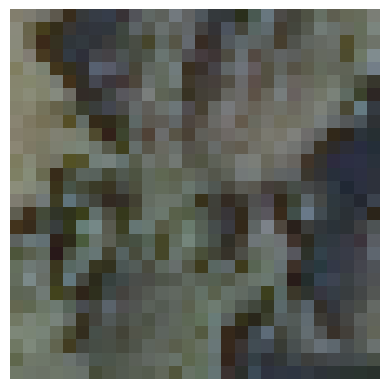

Trees


In [28]:
import matplotlib.pyplot as plt
from skimage import color
from skimage.feature import hog

# Visualizing one image
ix = 200  # Type a number between 0 and 99,999 inclusive

# Ensure the image is in a format that imshow can handle
img = np.squeeze(X_train_img[ix, :, :, 0:3])  # Only RGB channels
img = img / 255.0  # Ensure values are between 0 and 1 for proper display

# Check if the image is in the correct format for plotting
if img.shape[-1] == 3:  # Check if the image has 3 channels (RGB)
    plt.imshow(img.astype(float))  # Cast the image to float for display
    plt.axis('off')  # Optional: Hide axes for better visibility
    plt.show()
else:
    print("Image format is incorrect. It may not have 3 channels.")

# Tells what the image is
if Y_train.iloc[ix, 0] == 1:  # Use .iloc to access elements by integer index
    print('Barren Land')
elif Y_train.iloc[ix, 1] == 1:
    print('Trees')
elif Y_train.iloc[ix, 2] == 1:
    print('Grassland')
else:
    print('Other')


In [7]:
from skimage import color
from skimage.feature import hog

hog_features_map = []
for i in range(99999):
    image_sample = np.squeeze(X_train_img[i, :, :, 0:3])
    image_gray = color.rgb2gray(image_sample)
    feature= hog(image_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    hog_features_map.append(feature)

from sklearn.preprocessing import MinMaxScaler

# Convert HOG feature map to a numpy array
hog_features_map = np.array(hog_features_map)

# Initialize a MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler and transform the features
hog_features_normalized = scaler.fit_transform(hog_features_map)

In [8]:
from skimage.feature import local_binary_pattern

lbp_features_map = []

for i in range(99999):
    image_sample = np.squeeze(X_train_img[i, :, :, 0:3])
    image_gray = color.rgb2gray(image_sample)

    # Extract LBP image
    lbp_img = local_binary_pattern(image_gray, P=8, R=1, method='uniform')

    # Histogram with 59 bins for 'uniform' patterns
    hist, _ = np.histogram(lbp_img.ravel(), bins=np.arange(0, 60), range=(0, 59))

    # Normalize histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)

    # Append to list
    lbp_features_map.append(hist)


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [9]:
import numpy as np
import cv2

def extract_gabor_features(img):
    # Define Gabor kernels (different orientations and scales)
    kernels = []
    for theta in np.arange(0, np.pi, np.pi / 4):  # 4 orientations
        for lamda in [2, 4]:  # 2 wavelengths
            kernels.append(cv2.getGaborKernel((21, 21), 5.0, theta, lamda, 1.0, 0, ktype=cv2.CV_32F))

    gabor_features = []
    for kernel in kernels:
        filtered_img = cv2.filter2D(img, cv2.CV_32F, kernel)
        gabor_features.append(filtered_img.mean())

    return np.array(gabor_features)

gabor_features_map = []
for i in range(99999):
    img = np.squeeze(X_train_img[i, :, :, 0:3])
    # Convert image to uint8 before color conversion
    img = img.astype(np.uint8)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    gabor_features = extract_gabor_features(img_gray)
    gabor_features_map.append(gabor_features)

gabor_features_map = np.array(gabor_features_map)

In [10]:
from skimage import color
import cv2

def extract_color_histogram(img, bins=16):
    # Convert image to HSV color space
    # Convert image to uint8 before color conversion
    img = img.astype(np.uint8)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Extract histograms for Hue, Saturation, and Value channels
    hist_hue = cv2.calcHist([img_hsv], [0], None, [bins], [0, 256])
    hist_saturation = cv2.calcHist([img_hsv], [1], None, [bins], [0, 256])
    hist_value = cv2.calcHist([img_hsv], [2], None, [bins], [0, 256])

    # Normalize histograms
    hist_hue = hist_hue / hist_hue.sum()
    hist_saturation = hist_saturation / hist_saturation.sum()
    hist_value = hist_value / hist_value.sum()

    # Concatenate histograms into a single feature vector
    return np.concatenate([hist_hue.flatten(), hist_saturation.flatten(), hist_value.flatten()])

color_histograms = []
for i in range(99999):
    img = np.squeeze(X_train_img[i, :, :, 0:3])
    color_hist = extract_color_histogram(img)
    color_histograms.append(color_hist)

color_histograms = np.array(color_histograms)

In [13]:
combined_features_handcrafted = np.concatenate((hog_features_map, lbp_features_map), axis=1)


In [14]:
combined_features_handcrafted_1 = np.concatenate((combined_features_handcrafted, color_histograms, gabor_features_map), axis=1)
combined_features = combined_features_handcrafted_1

In [15]:

# Convert to GPU arrays (if you want to use cuML)
import cupy as cp
X_train_f_gpu = cp.asarray(combined_features)
Y_train_gpu = cp.asarray(Y_train)

# Check the shape of the combined features
print('Shape of combined features:', combined_features.shape)

# Train-test split on GPU
from cuml.model_selection import train_test_split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_train_f_gpu, Y_train_gpu, test_size=0.2, random_state=42)

# Convert labels to single class (0, 1, 2, 3) for multi-class classification
y_train_f = cp.argmax(y_train_f, axis=1)
y_test_f = cp.argmax(y_test_f, axis=1)


Shape of combined features: (99999, 259)


In [16]:
# Train One-vs-One SVM using cuML
from cuml.svm import SVC
from sklearn.metrics import accuracy_score # Import accuracy_score
from sklearn.metrics import classification_report # Import classification report

# One-vs-One
svm_ovo = SVC(kernel='linear')  # Removed decision_function_shape
svm_ovo.fit(X_train_f, y_train_f)
y_pred_ovo = svm_ovo.predict(X_test_f)
ovo_accuracy = accuracy_score(y_test_f.get(), y_pred_ovo.get()) # Use .get() to convert to numpy array if needed
print("OvO Accuracy:", ovo_accuracy)

[2025-04-26 22:51:54.690] [CUML] [warning] SVC with the linear kernel can be much faster using the specialized solver provided by LinearSVC. Consider switching to LinearSVC if tranining takes too long.
OvO Accuracy: 0.9508475423771189


In [17]:
print(classification_report(y_test_f.get(), y_pred_ovo.get()))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      5153
           1       0.95      0.96      0.95      4021
           2       0.89      0.87      0.88      3624
           3       0.97      0.98      0.97      7201

    accuracy                           0.95     19999
   macro avg       0.94      0.94      0.94     19999
weighted avg       0.95      0.95      0.95     19999



In [18]:
from cuml.svm import SVC, LinearSVC

# --- OvR (Linear Kernel) ---
svm_ovr = LinearSVC(multi_class='ovr')  # Explicit OvR
svm_ovr.fit(X_train_f, y_train_f)
y_pred_ovr = svm_ovr.predict(X_test_f)
print("\nOvR Results:")
print(classification_report(y_test_f.get(), y_pred_ovr.get()))
print("OvR Accuracy:", accuracy_score(y_test_f.get(), y_pred_ovr.get()))

[2025-04-26 23:05:24.817] [CUML] [warning] L-BFGS: max iterations reached
[2025-04-26 23:05:24.817] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-04-26 23:05:29.927] [CUML] [warning] L-BFGS: max iterations reached
[2025-04-26 23:05:29.927] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.

OvR Results:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5153
           1       0.88      0.93      0.91      4021
           2       0.85      0.79      0.82      3624
           3       0.93      0.93      0.93      7201

    accuracy                           0.91     19999
   macro avg       0.90      0.90      0.90     19999
weighted avg      

In [19]:
import joblib  # or use pickle

# Saving the OvO model
joblib.dump(svm_ovo, 'svm_ovo_model.pkl')

# Saving the OvR model
joblib.dump(svm_ovr, 'svm_ovr_model.pkl')


['svm_ovr_model.pkl']

In [20]:
# Loading the OvO model
svm_ovo_loaded = joblib.load('svm_ovo_model.pkl')

# Loading the OvR model
svm_ovr_loaded = joblib.load('svm_ovr_model.pkl')


In [22]:
y_pred_ovr = svm_ovr_loaded.predict(X_test_f)
print("\nOvR Results:")
print(classification_report(y_test_f.get(), y_pred_ovr.get()))
print("OvR Accuracy:", accuracy_score(y_test_f.get(), y_pred_ovr.get()))


OvR Results:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5153
           1       0.88      0.93      0.91      4021
           2       0.85      0.79      0.82      3624
           3       0.93      0.93      0.93      7201

    accuracy                           0.91     19999
   macro avg       0.90      0.90      0.90     19999
weighted avg       0.91      0.91      0.91     19999

OvR Accuracy: 0.912045602280114


In [24]:
y_pred_ovo = svm_ovo_loaded.predict(X_test_f)
print("\nOvR Results:")
print(classification_report(y_test_f.get(), y_pred_ovo.get()))
print("OvR Accuracy:", accuracy_score(y_test_f.get(), y_pred_ovo.get()))


OvR Results:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      5153
           1       0.95      0.96      0.95      4021
           2       0.89      0.87      0.88      3624
           3       0.97      0.98      0.97      7201

    accuracy                           0.95     19999
   macro avg       0.94      0.94      0.94     19999
weighted avg       0.95      0.95      0.95     19999

OvR Accuracy: 0.9508475423771189
